In [1]:
import arviz as az

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pickle
import timeit
import aesara.tensor as at
from arviz.plots import plot_utils as azpu
import pandas as pd
import decimal
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import arviz as az
import matplotlib.gridspec as gridspec

from pymc import HalfCauchy, Model, Normal,sample, Uniform
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v5.10.4


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")


In [3]:
pwd

'/Users/anshigupta/2D System'

In [4]:
#################################################
# import the data you generated here!
######################################################
with open('data_simulation_2D.pickle', 'rb') as f:
    
    betar_val,Kr_val,nr_val,a1_val,betaa_val,Ka_val,na_val, a2_val,x1_0,x2_0,fT,t_ori,X1_ssa,X2_ssa = pickle.load(f)

dt  =t_ori[1]-t_ori[0]
n_seq = len(t_ori)

betar_val,Kr_val,nr_val,a1_val,betaa_val,Ka_val,na_val, a2_val
########################################################
# put your directory to save results
########################################################
path = '/Users/anshigupta/2D System'

In [5]:
def return_data(n_data,type_data,t_last):
    # This function is only for bring the data.
    x1_ssa = X1_ssa
    x2_ssa = X2_ssa

 
    if type_data == 'SSA':
        x1 = x1_ssa.copy()
        x2 = x2_ssa.copy()
    
    XX1 = x1[:-1]
    dXX1 = x1[1:]- x1[:-1]
    XX2 = x2[:-1]
    dXX2 = x2[1:]- x2[:-1]
    
    return XX1[:t_last], dXX1[:t_last], XX2[:t_last], dXX2[:t_last]

8999
[ 0.  1.  0. ...  0. -1.  0.]
[0. 0. 0. ... 0. 0. 0.]


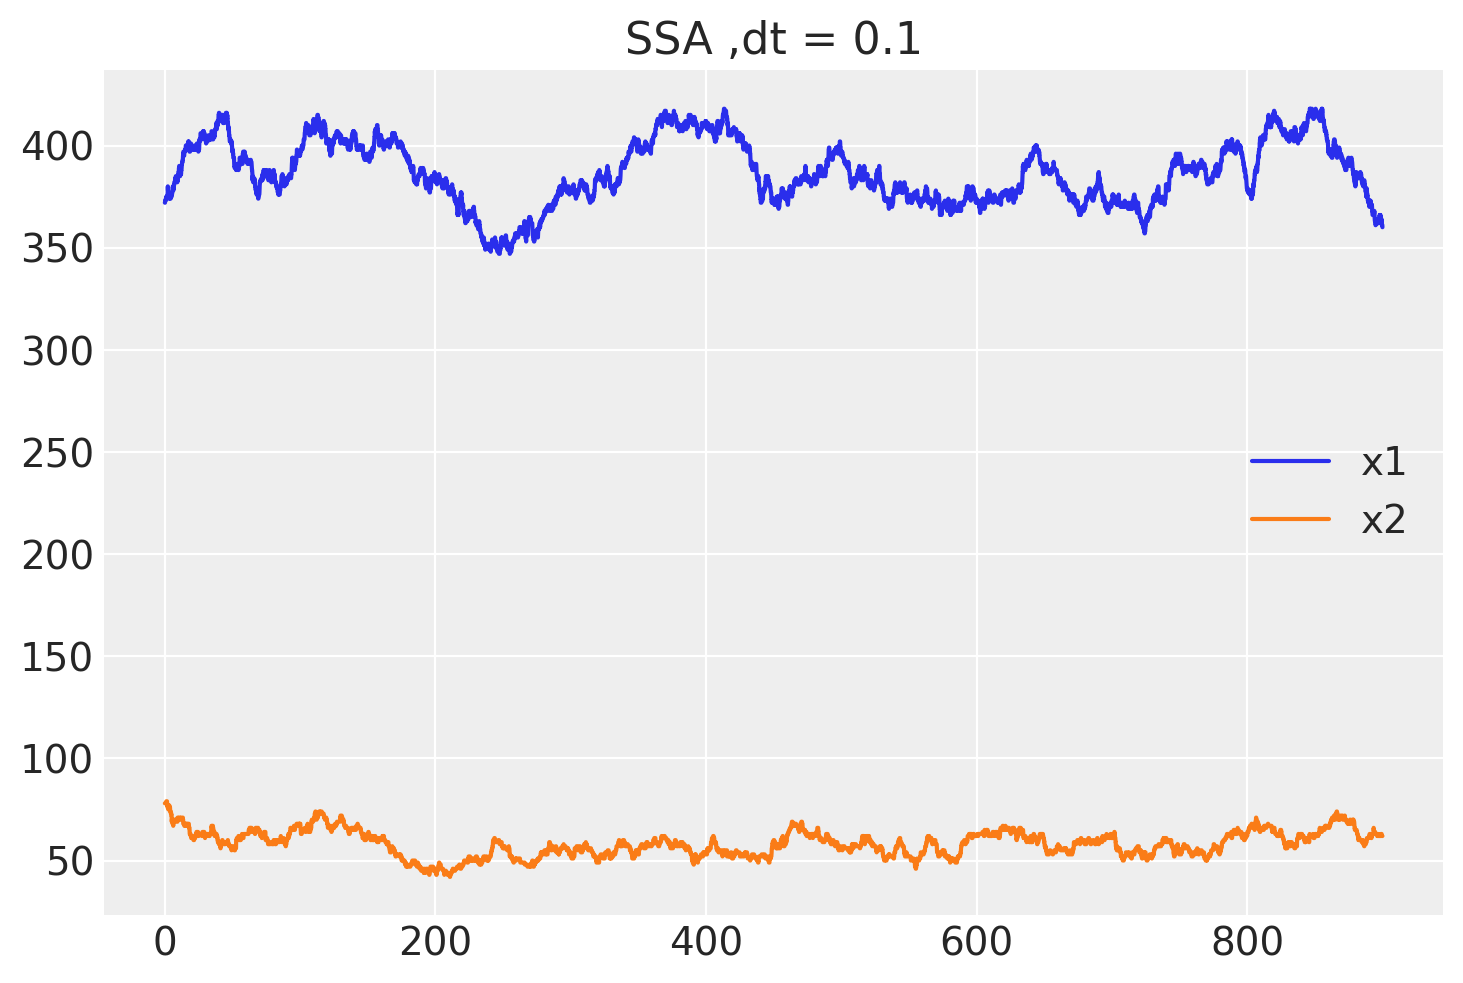

In [6]:
######################################################################
# call the data
# if you examine by varying the data (e.g. dt size, number of data, etc)
#################################################
Type_data = ['SSA']
n_type = 0

# decide length of trajectory 
t_last = 8999

# decide dt
DT= [0.1]
n_dt = 0 

# which trajectories will be used. 
n_data = 0

type_data = Type_data[n_type]
dt = DT[n_dt]

XX1, dXX1, XX2, dXX2 = return_data(n_data,type_data,t_last)

plt.plot(t_ori[:t_last],XX1,label = 'x1')
plt.plot(t_ori[:t_last], XX2, label = 'x2')
plt.title(type_data+' ,dt = %s' %dt)
plt.legend()
len(t_ori[:t_last])
print(len(XX1))
print(dXX1)
print(dXX2)

# CLE

In [7]:
def mcmc_model_cle(x1t,x2t, dx1t, dx2t, dt):
    
   
    with Model() as model:

        ####################################################
        # change prior 
        # You need to define other variables
        #####################################################
        
        #betar =  pm.Laplace("betar",mu = betar_val*0.9, b = betar_val*0.1)
        betar=pm.Exponential("betar", 0.2)
        #Kr=Kr_val
        Kr =pm.Laplace("Kr",mu = Kr_val*0.9, b = Kr_val*0.2)
        #Kr=pm.Exponential("Kr", 0.5)
        nr = nr_val
        a2 = pm.HalfNormal("a2",sigma =4)
        betaa=pm.Exponential("betaa", 0.5)
        #betaa =  pm.HalfNormal("betaa",sigma =10)
        
        Ka = pm.Laplace("Ka",Ka_val*0.9, b = Ka_val*0.2)
        #Ka=Ka_val
        #Ka=pm.Exponential("Ka", 0.5)
        na = na_val
        a1 = pm.HalfNormal("a1",sigma =4)
        
        
        ##########################################################
        # You have to change F and G 
        ###############################################################
      
        
        F1=dt*(betaa*(x2t**na)/(x2t**na + Ka**na)  - a1*x1t)
        F2=dt*( betar*(Kr**nr)/(x1t**nr + Kr**nr)  - a2*x2t)
        
        G1 = pm.math.sqrt(dt)*(pm.math.sqrt(pm.math.abs(betaa*(x2t**na)/(x2t**na + Ka**na)) + pm.math.abs(a1*x1t) ))

        G2= pm.math.sqrt(dt)*(pm.math.sqrt(pm.math.abs(betar*(Kr**nr)/(x1t**nr + Kr**nr)) + pm.math.abs(a2*x2t) ) )
        


        #define likelihood
        mu1 = F1
        mu2 = F2
        sig1 = G1
        sig2 = G2
        likelihood1 = pm.Normal("obs1", mu=mu1, sigma=sig1, observed=dx1t)
        likelihood2 = pm.Normal("obs2", mu=mu2, sigma=sig2, observed=dx2t)
        likelihood=likelihood1+likelihood2
        step = pm.step_methods.hmc.nuts.NUTS(target_accept  = 0.9)
        trace = sample(10000, step = step,cores = 4,return_inferencedata=True,tune=3000,chains = 4)

        
        return trace

In [8]:
def analysis_CLE(trace):
    colume = list(trace.posterior.data_vars)
    Mean=[]
    Mode = []
    Sd = []
    Samples =[]
    tune = 3000
    for name in colume:

        Mean.append(az.summary(trace, kind="stats")['mean'][name])
        Sd.append(az.summary(trace, kind="stats")['sd'][name])
        sam =[]
        for i in range(4):
            samples = trace.posterior[name][i][tune:]
            sam.append(samples)
        sam = np.array(sam).flatten()
        Samples.append(sam)
        counts, left = np.histogram(sam, bins = 10000)
        l_max = np.argmax(counts)
        Mode.append((left[l_max] + left[l_max+1])/2)

    
    true_val =[Kr_val,Ka_val,betar_val, a2_val,betaa_val,a1_val]
    table = pd.DataFrame(index = [colume], data= np.vstack([true_val,Mode, Mean,Sd]).T,columns = ['true','mode','mean','std'])
    print(table)
    pd.to_pickle(table,path+"CLE_"+type_data+'_%d_table.pkl' % n_data)  
    
    with open(path+'CLE_'+type_data+'_%d.pickle'% n_data, 'wb') as f:
        pickle.dump([Samples,dt], f)

        

In [9]:
trace_cle_ = mcmc_model_cle(XX1, XX2,dXX1, dXX2, dt)

/Users/anshigupta/anaconda3/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 448 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
analysis_CLE(trace_cle_)

        true       mode    mean    std
Kr     30.00  27.591819  32.565  8.251
Ka     20.00  18.073344  19.282  4.985
betar  10.00  14.381185  16.032  3.477
a2      0.02   0.020729   0.021  0.001
betaa   5.00   4.907928   4.997  0.336
a1      0.01   0.009762   0.010  0.000


In [11]:
trace_cle_

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [12]:

def mcmc_model_cle1(x1t, x2t, dx1t, dx2t, dt, iterations=1):
    traces = []  

    for _ in range(iterations):
        with pm.Model() as model:
            
            betar = pm.Exponential("betar", 0.2)
            Kr = pm.Laplace("Kr", mu=Kr_val * 0.9, b=Kr_val * 0.2)
            nr = nr_val
            a2 = pm.HalfNormal("a2", sigma=4)
            betaa = pm.Exponential("betaa", 0.5)
            Ka = pm.Laplace("Ka", mu=Ka_val * 0.9, b=Ka_val * 0.2)
            na = na_val
            a1 = pm.HalfNormal("a1", sigma=4)

            
            F1 = dt * (betaa * (x2t**na) / (x2t**na + Ka**na) - a1 * x1t)
            F2 = dt * (betar * (Kr**nr) / (x1t**nr + Kr**nr) - a2 * x2t)

            G1 = pm.math.sqrt(dt) * (pm.math.sqrt(pm.math.abs(betaa * (x2t**na) / (x2t**na + Ka**na)) + pm.math.abs(a1 * x1t)))
            G2 = pm.math.sqrt(dt) * (pm.math.sqrt(pm.math.abs(betar * (Kr**nr) / (x1t**nr + Kr**nr)) + pm.math.abs(a2 * x2t)))

           
            mu1 = F1
            mu2 = F2
            sig1 = G1
            sig2 = G2
            likelihood1 = pm.Normal("obs1", mu=mu1, sigma=sig1, observed=dx1t)
            likelihood2 = pm.Normal("obs2", mu=mu2, sigma=sig2, observed=dx2t)

           
            step = pm.step_methods.hmc.nuts.NUTS(target_accept=0.9)
            trace = pm.sample(10000, step=step, cores=4, tune=3000, chains=4)
            
            traces.append(trace)  
    return traces


traces = mcmc_model_cle1(XX1, XX2,dXX1, dXX2, dt, iterations=10)



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 415 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 406 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 413 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 478 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 410 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 409 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 416 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 450 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 398 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betar, Kr, a2, betaa, Ka, a1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 407 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:

def analysis_CLE1(traces):
    columns = list(traces[0].posterior.data_vars)  

    means = []
    modes = []
    stds = []
    all_samples = []  
    
    tune = 3000
    
    for trace in traces:
        trace_mean = []
        trace_mode = []
        trace_std = []
        trace_samples = []

        for name in columns:
            trace_mean.append(az.summary(trace, kind="stats")['mean'][name])
            trace_std.append(az.summary(trace, kind="stats")['sd'][name])

            
            samples = trace.posterior[name][:, tune:]
            trace_samples.append(samples)
            counts, bin_edges = np.histogram(samples, bins=10000)
            bin_width = bin_edges[1] - bin_edges[0]
            trace_mode.append(bin_edges[np.argmax(counts)] + bin_width / 2)

        
        means.append(trace_mean)
        modes.append(trace_mode)
        stds.append(trace_std)
        all_samples.extend(trace_samples)  
    
    means = np.array(means)
    modes = np.array(modes)
    stds = np.array(stds)

    # Plot histograms
    for i, column in enumerate(columns):
        plt.figure(figsize=(8, 6))
        plt.hist(modes[:, i], bins=50, alpha=0.5, label='Mode')
        plt.hist(means[:, i], bins=50, alpha=0.5, label='Mean')
        plt.title(f'{column} Histogram')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        #plt.savefig(f'{column}_histogram.png')  
        plt.show()

    return means, modes, stds, all_samples  



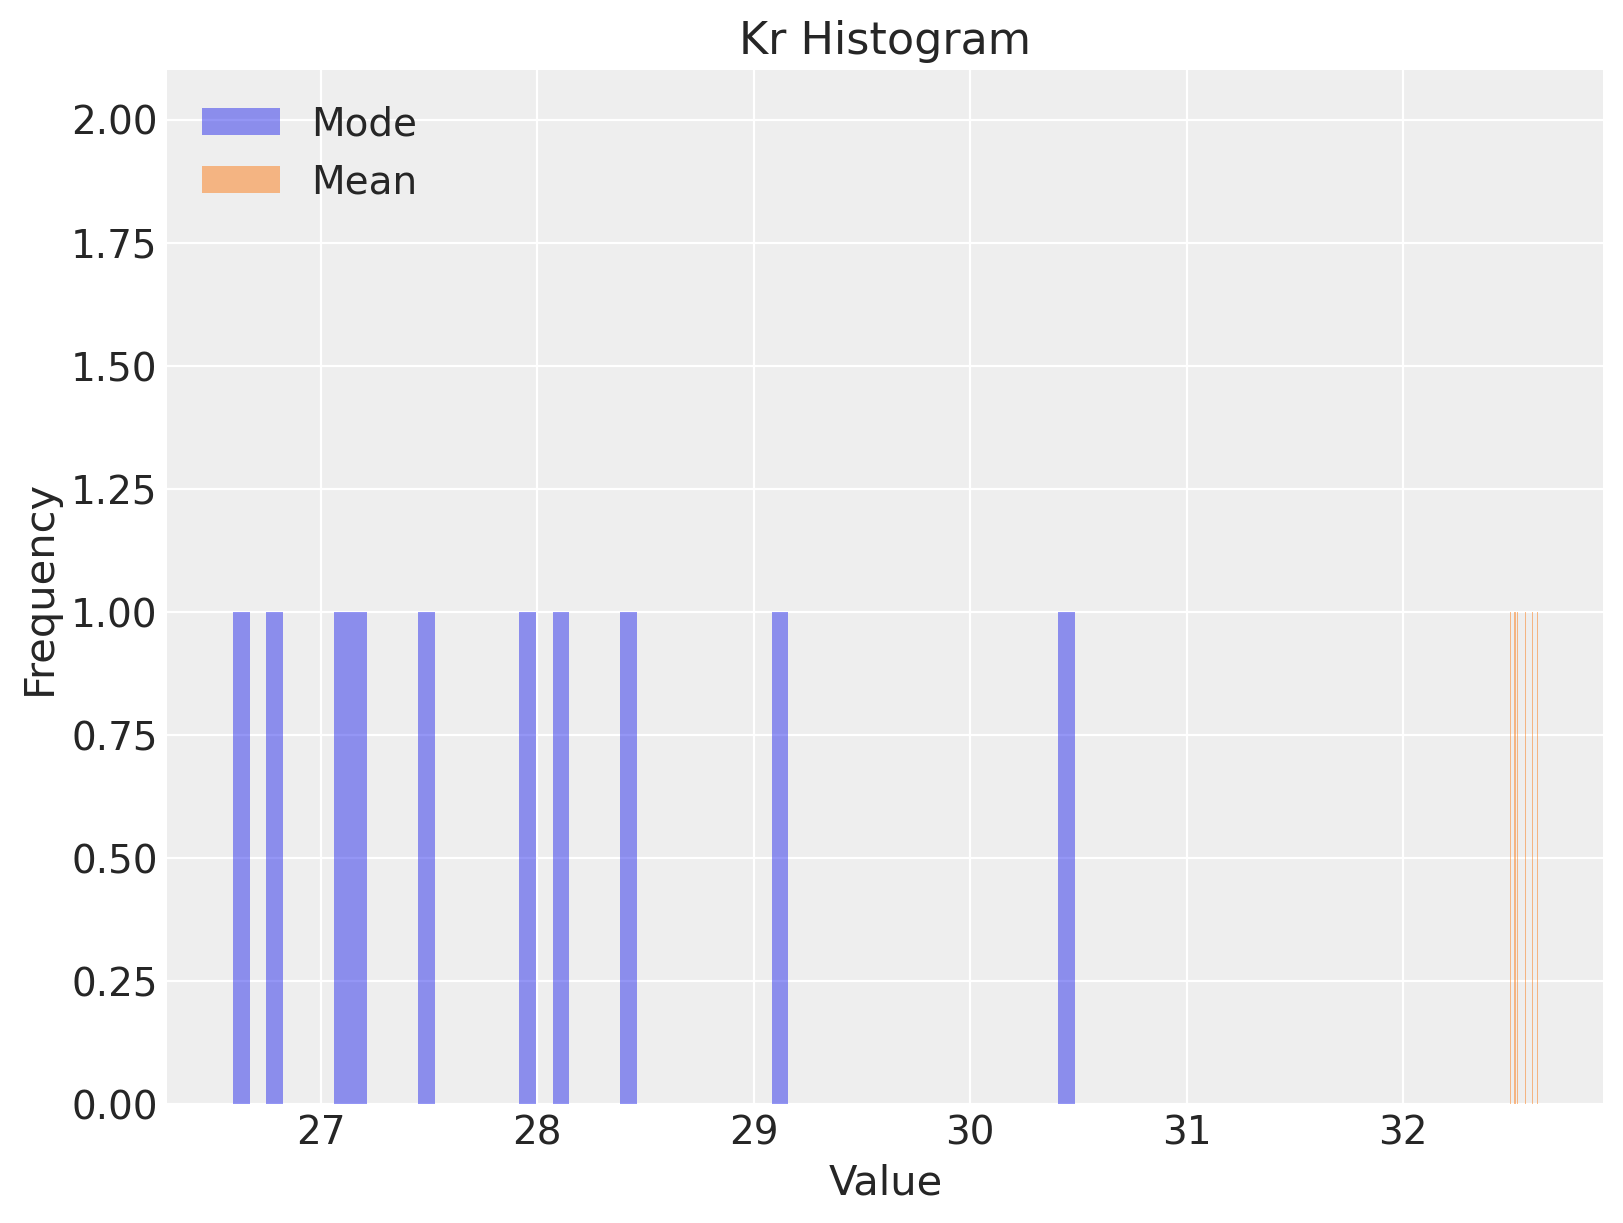

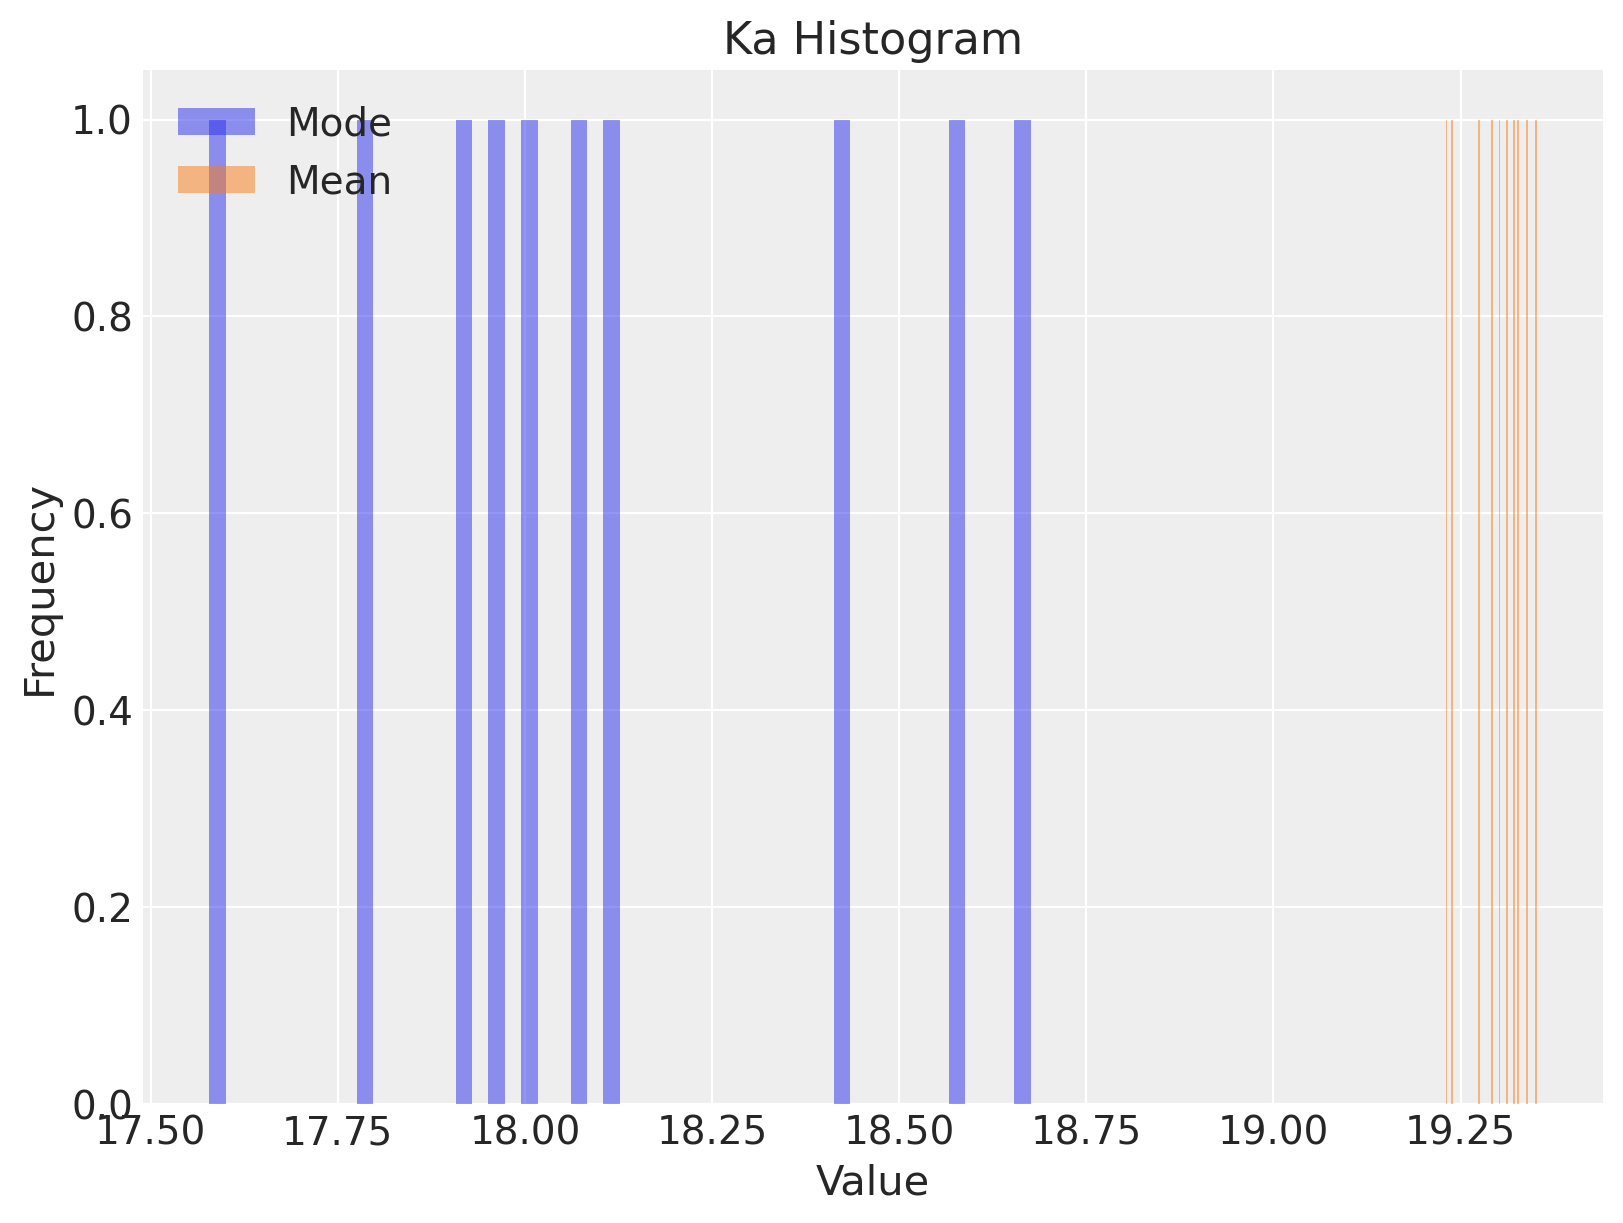

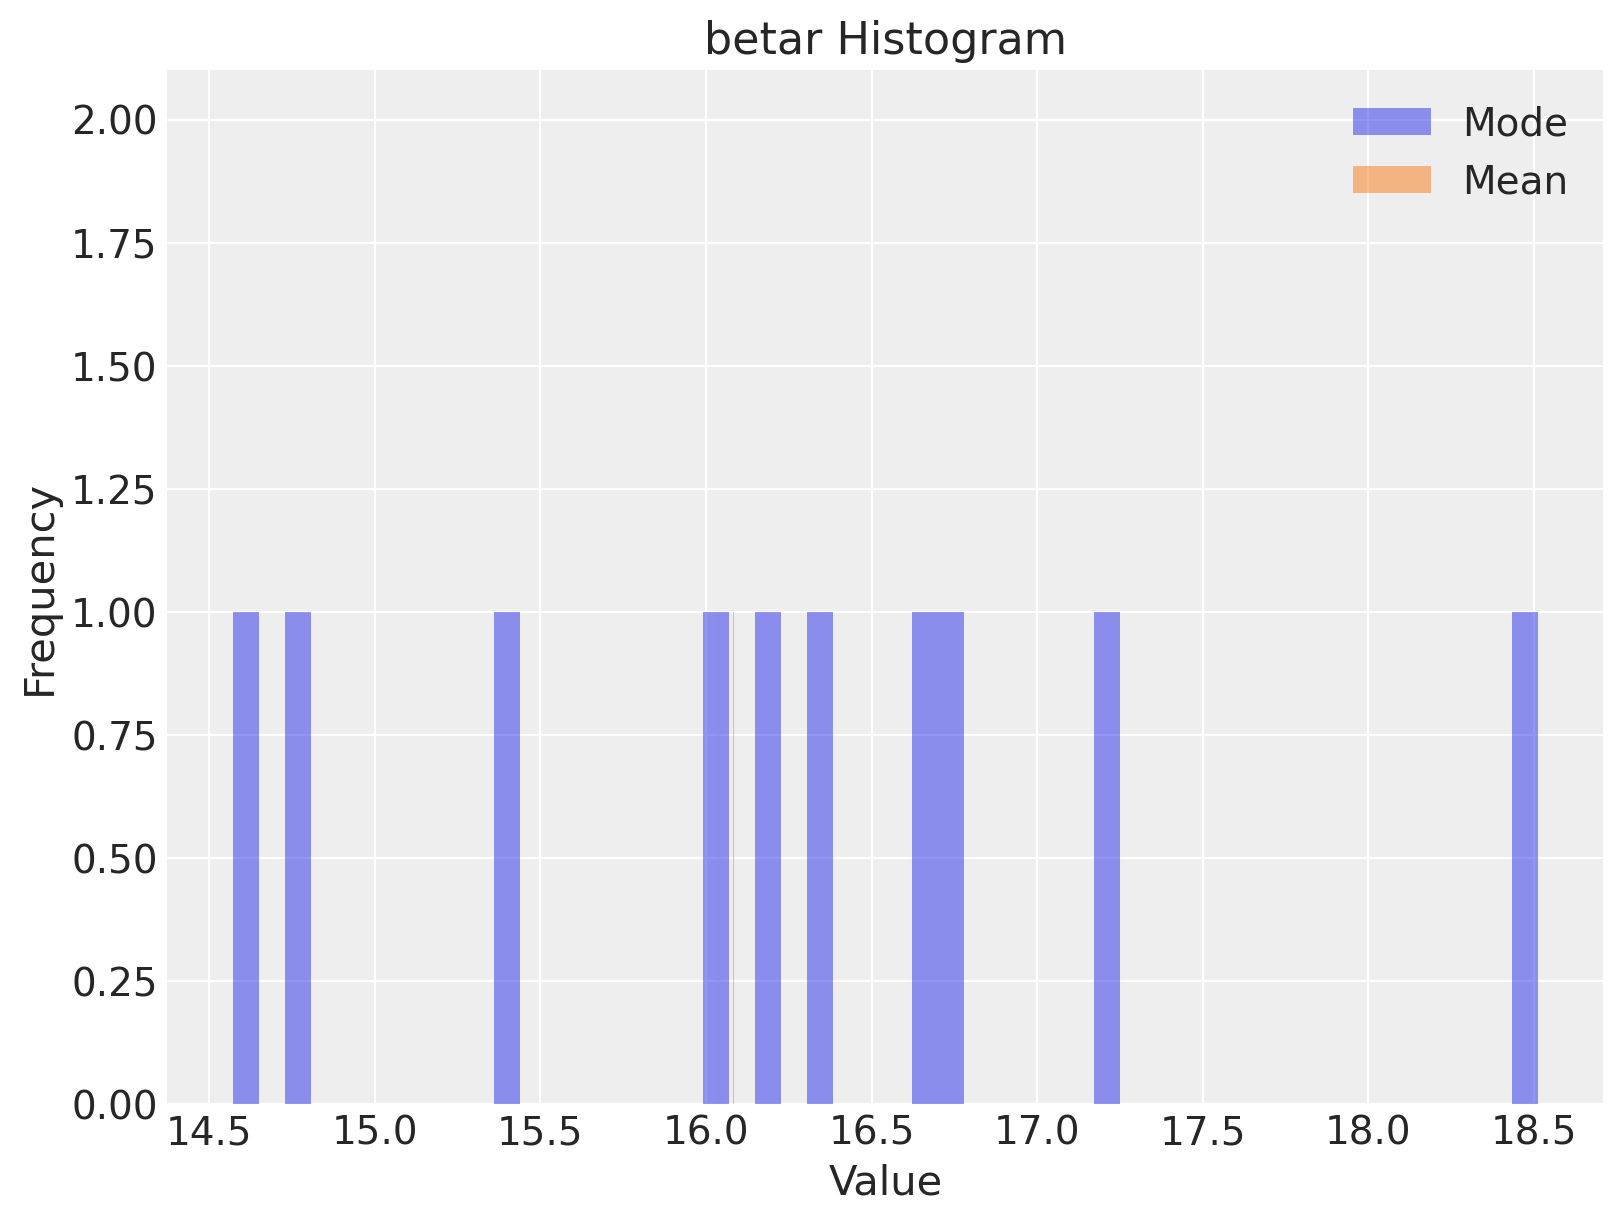

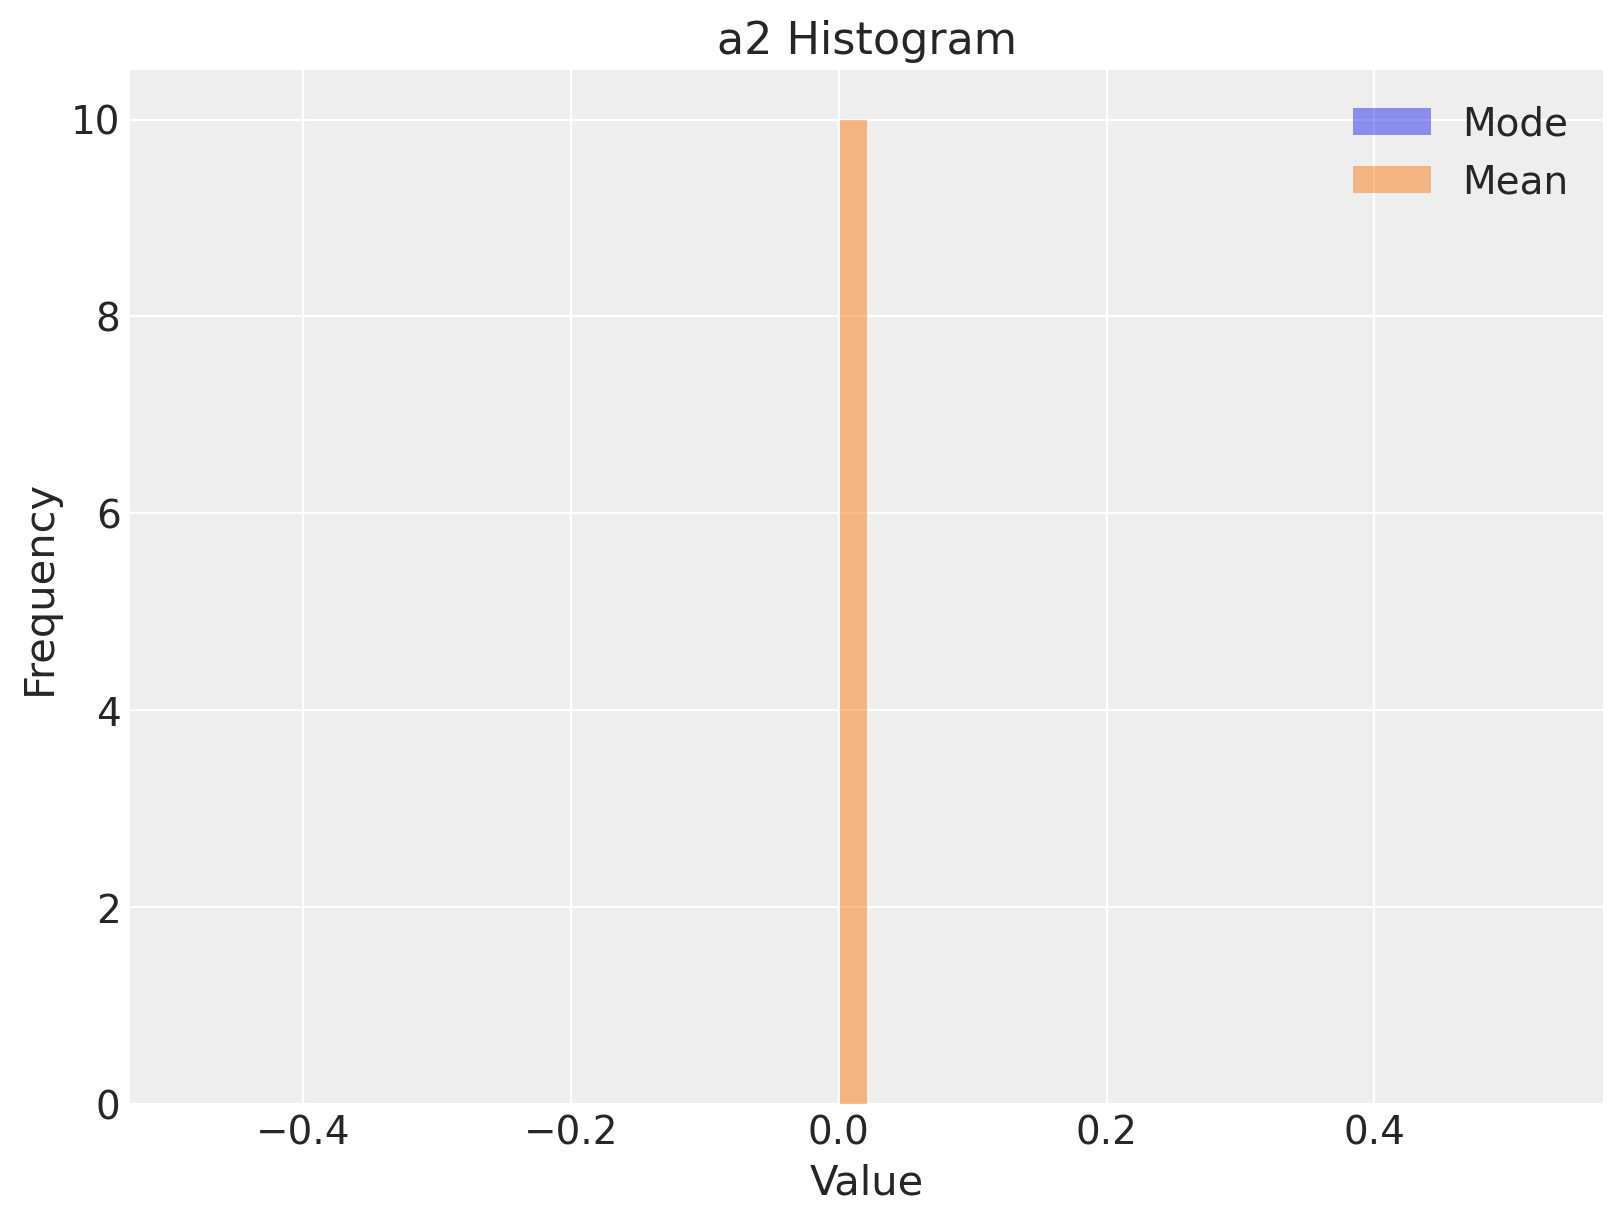

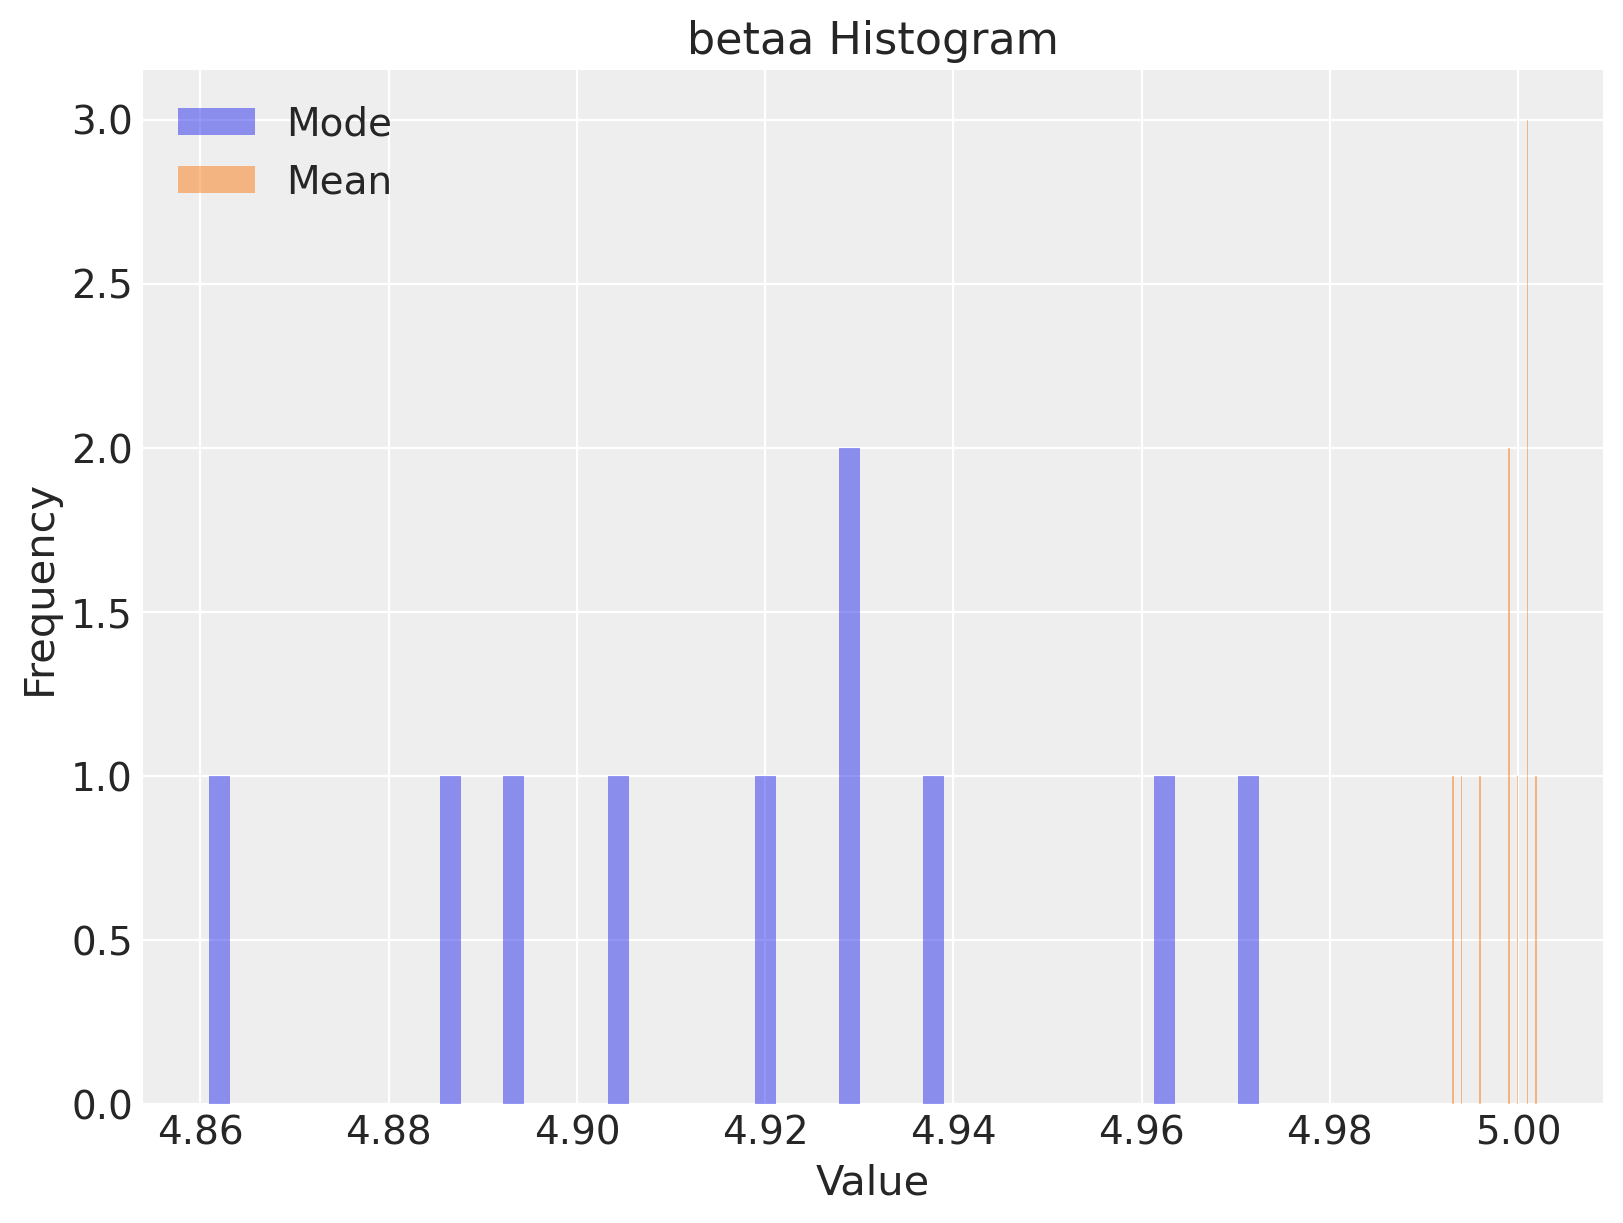

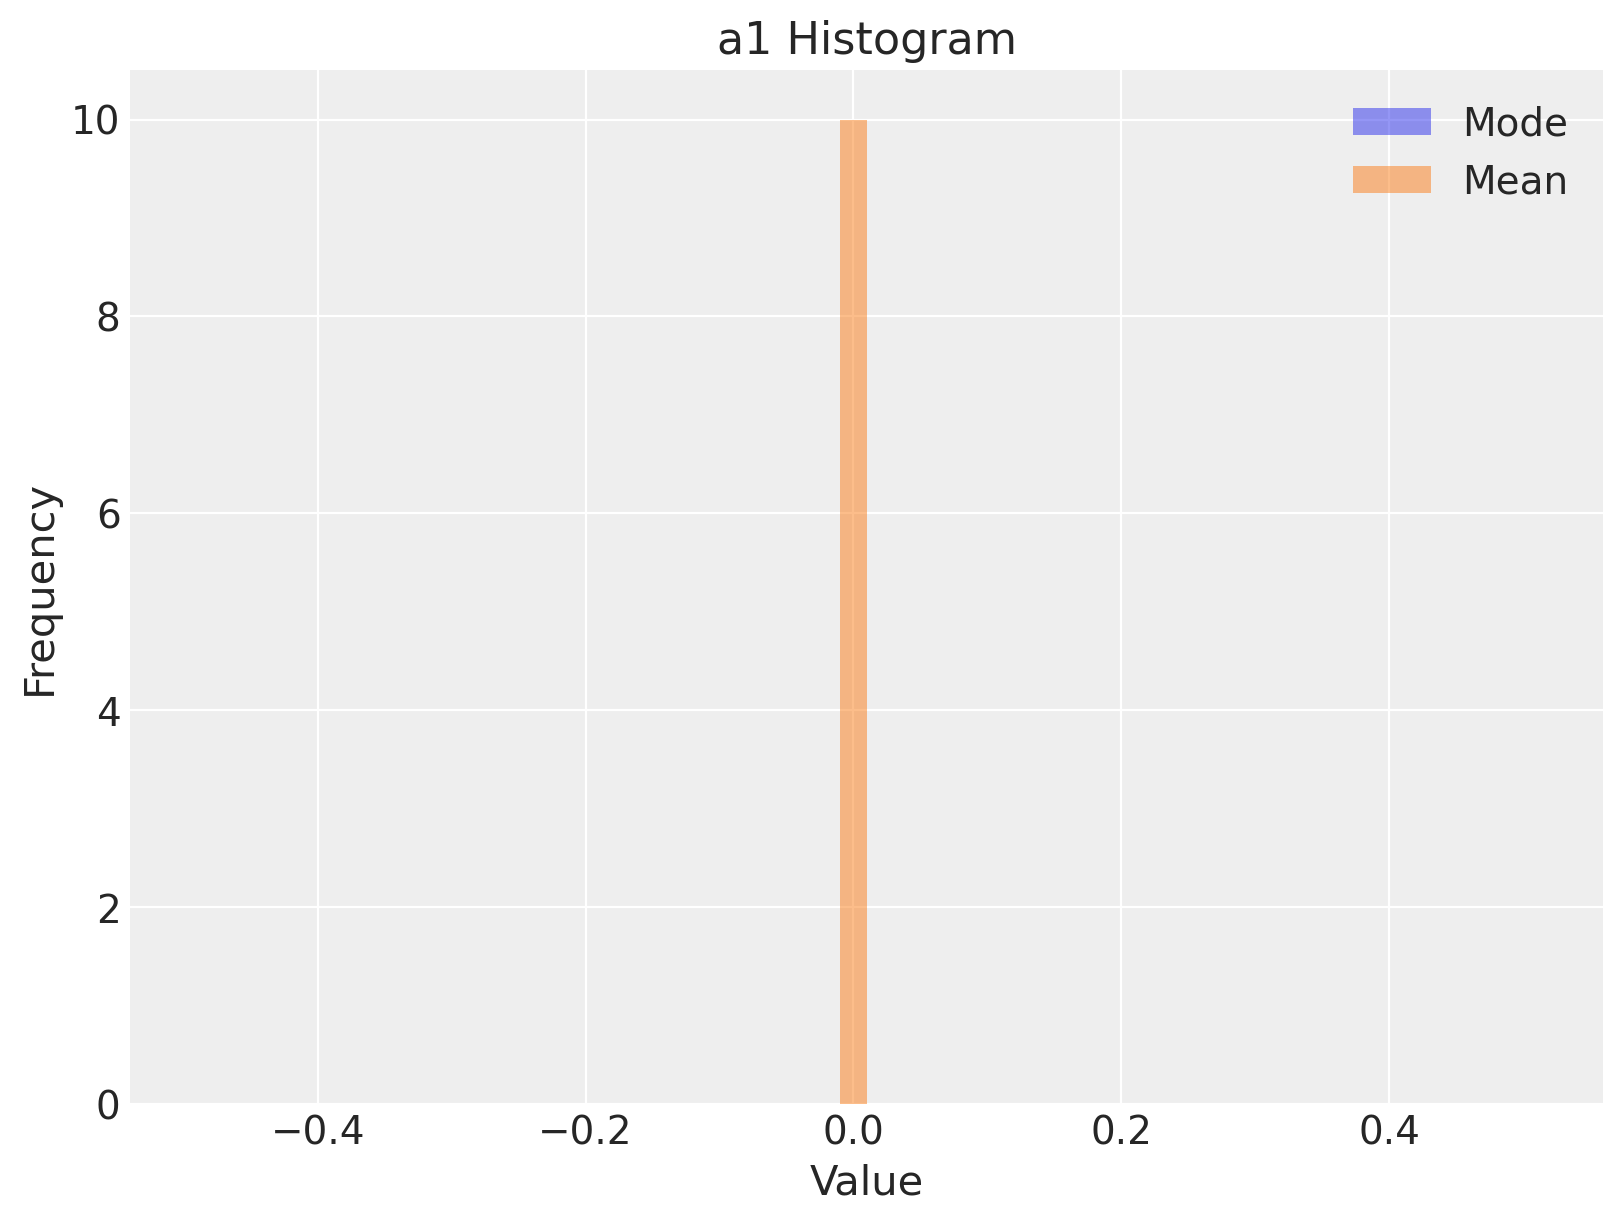

(array([[3.2520e+01, 1.9352e+01, 1.6046e+01, 2.1000e-02, 5.0020e+00,
         1.0000e-02],
        [3.2623e+01, 1.9302e+01, 1.6027e+01, 2.1000e-02, 4.9990e+00,
         1.0000e-02],
        [3.2526e+01, 1.9312e+01, 1.6018e+01, 2.1000e-02, 5.0000e+00,
         1.0000e-02],
        [3.2497e+01, 1.9338e+01, 1.6035e+01, 2.1000e-02, 5.0010e+00,
         1.0000e-02],
        [3.2427e+01, 1.9327e+01, 1.6084e+01, 2.1000e-02, 5.0010e+00,
         1.0000e-02],
        [3.2534e+01, 1.9239e+01, 1.6050e+01, 2.1000e-02, 4.9940e+00,
         1.0000e-02],
        [3.2566e+01, 1.9276e+01, 1.6050e+01, 2.1000e-02, 4.9960e+00,
         1.0000e-02],
        [3.2429e+01, 1.9293e+01, 1.6067e+01, 2.1000e-02, 4.9990e+00,
         1.0000e-02],
        [3.2596e+01, 1.9322e+01, 1.6010e+01, 2.1000e-02, 5.0010e+00,
         1.0000e-02],
        [3.2514e+01, 1.9230e+01, 1.6041e+01, 2.1000e-02, 4.9930e+00,
         1.0000e-02]]),
 array([[2.71095268e+01, 1.84302380e+01, 1.60629335e+01, 2.06761512e-02,
         4.9296

In [14]:
analysis_CLE1(traces)

array([[<Axes: title={'center': 'Kr'}>, <Axes: title={'center': 'Kr'}>],
       [<Axes: title={'center': 'Ka'}>, <Axes: title={'center': 'Ka'}>],
       [<Axes: title={'center': 'betar'}>,
        <Axes: title={'center': 'betar'}>],
       [<Axes: title={'center': 'a2'}>, <Axes: title={'center': 'a2'}>],
       [<Axes: title={'center': 'betaa'}>,
        <Axes: title={'center': 'betaa'}>],
       [<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a1'}>]],
      dtype=object)

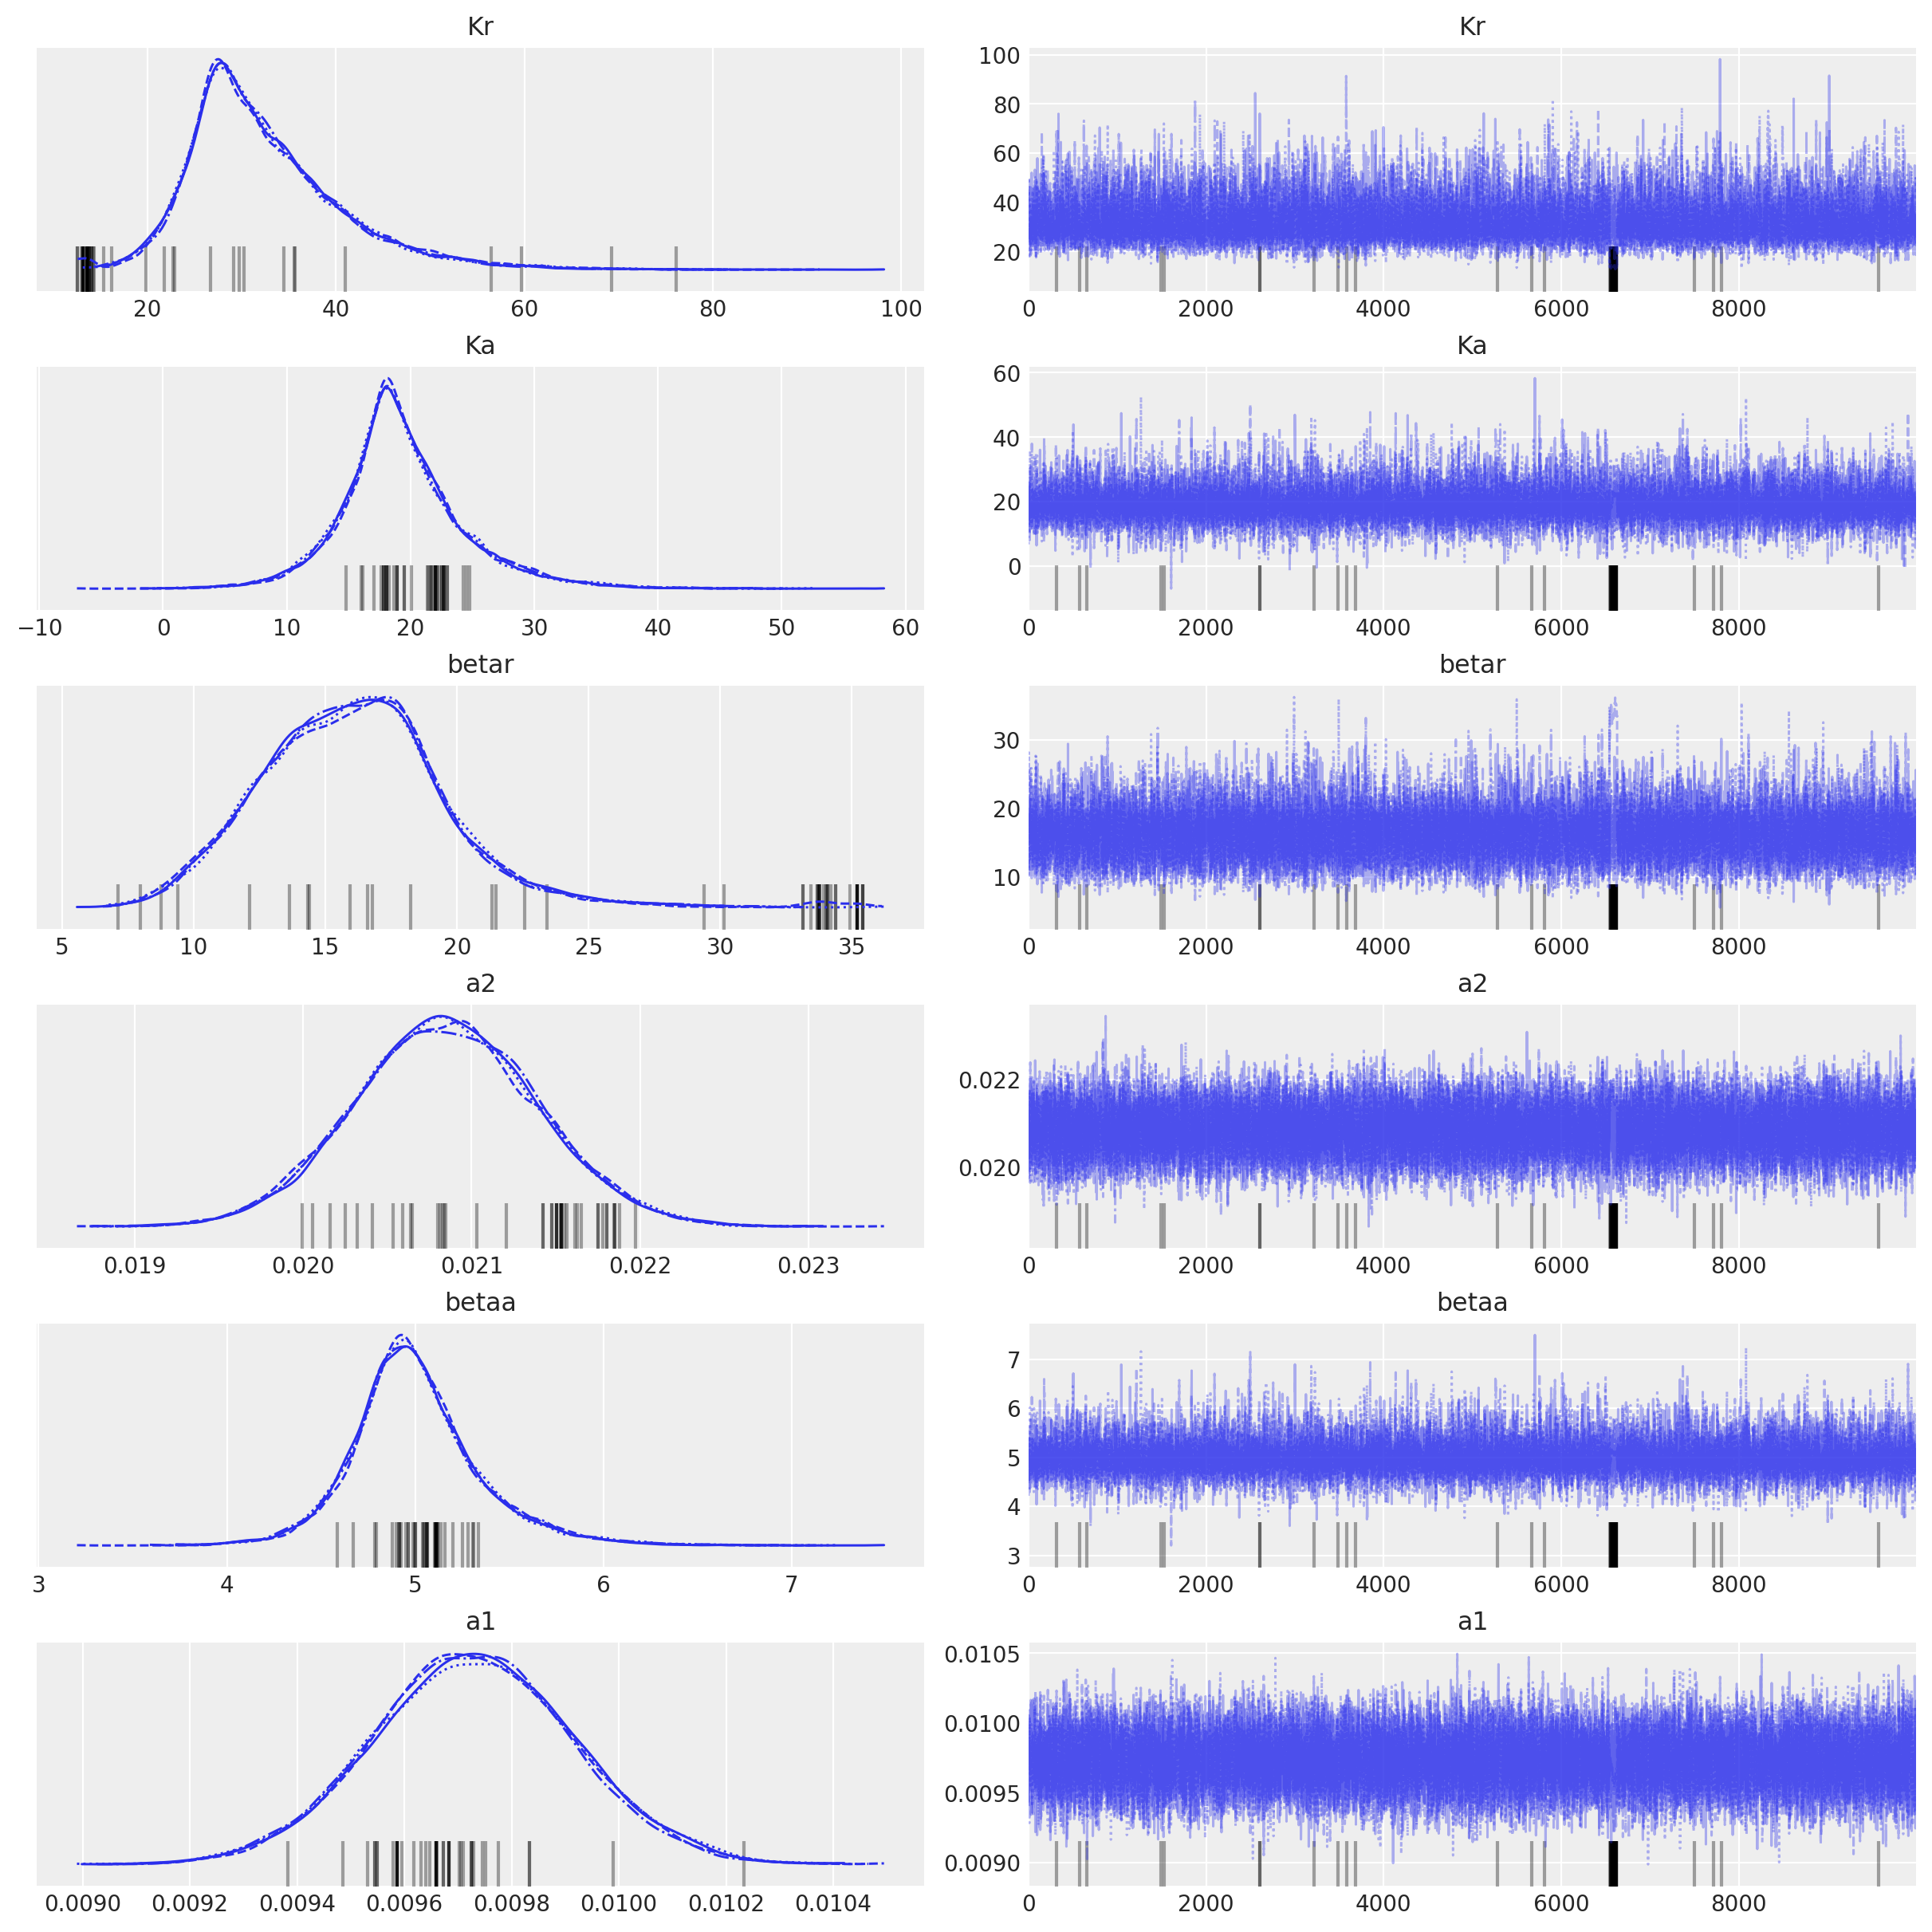

In [26]:
az.plot_trace(traces[1])